In [1]:
# import relevant libraries
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix,accuracy_score, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, shuffle
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=(FutureWarning, UserWarning))

# Set pandas to display 100 x 100 rows and columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
# import data
df_merge = pd.read_csv('./data/weather_train_test.csv')

## FEATURE ENGINEERING

**Wet bulb temperature:**
The temperature of the atmospheric air measured with the help of the thermometer when the bulb of the thermometer is covered by the wet cloth.

**Dew point temperature:**
The temperature of air recorded by a thermometer when water vapour in the air begins to condense or dew is formed.
Dewpoint is an absolute measure of how much moisture is in the air.

|Dewpoint|How it feels|
|-|-|
|<55°F|Dry|
|55-60°F|Comfortable|
|60-64°F|Rather Humid|
|65-69°F|Humid|
|70-75°F|Very Humid|
|>75°F|Oppressive|


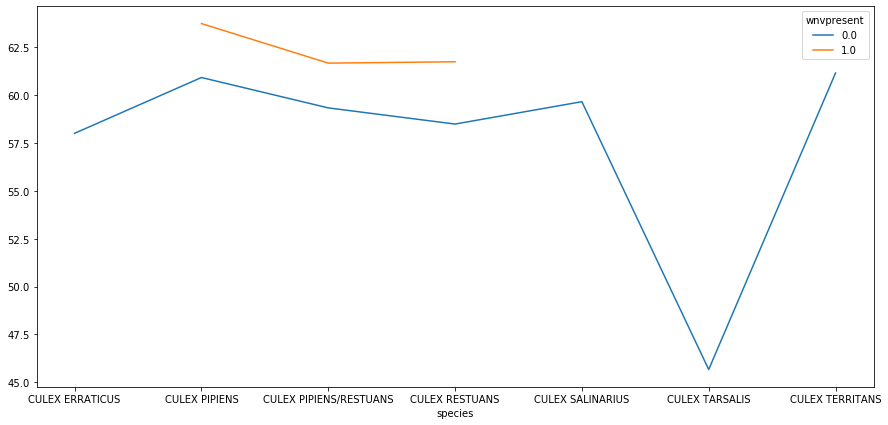

In [3]:
# plot data by amanda
# Take a look at what effect dew point has on the populations of mosquitos 
# (by breed) and whether wnv present or not. Apparently, mosquitos infected by
# WNV is quite rare.
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df_merge.groupby(['species','wnvpresent']).mean()['dewpoint'].unstack().plot(ax=ax);

In [9]:
df_merge.groupby(['species','wnvpresent']).mean()['dewpoint']

species                 wnvpresent
CULEX ERRATICUS         0.0           58.000000
CULEX PIPIENS           0.0           60.912973
                        1.0           63.729167
CULEX PIPIENS/RESTUANS  0.0           59.326726
                        1.0           61.664122
CULEX RESTUANS          0.0           58.482349
                        1.0           61.734694
CULEX SALINARIUS        0.0           59.651163
CULEX TARSALIS          0.0           45.666667
CULEX TERRITANS         0.0           61.148649
Name: dewpoint, dtype: float64

In [12]:
df_merge.groupby(['species','wnvpresent']).mean()['dewpoint'].unstack()

wnvpresent,0.0,1.0
species,,
CULEX ERRATICUS,58.000000,NaN
CULEX PIPIENS,60.912973,63.729167
CULEX PIPIENS/RESTUANS,59.326726,61.664122
CULEX RESTUANS,58.482349,61.734694
CULEX SALINARIUS,59.651163,NaN
CULEX TARSALIS,45.666667,NaN
CULEX TERRITANS,61.148649,NaN


It is known that warmer temperatures, elevated humidity, and heavy precipitation results in an increase in the relative rate of human WNV infection. This graph the relationship between the species that carry the virus and the dewpoint. As expected, the higher the dew point temperature, we observe the presence of the WNV. 

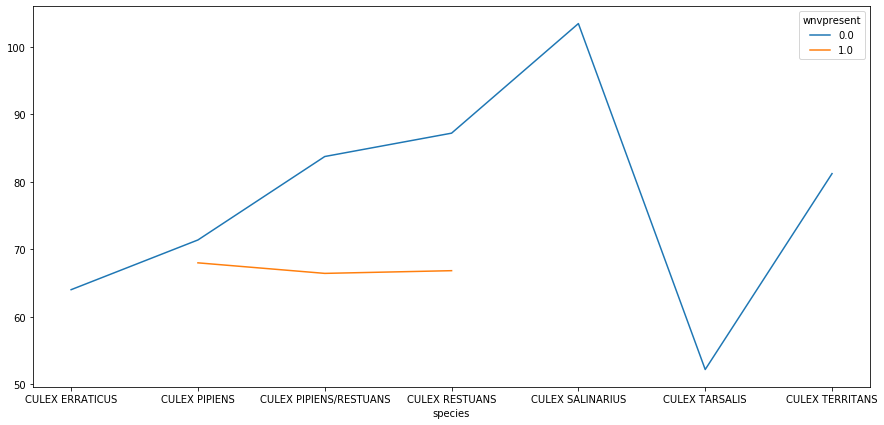

In [20]:
# plot data by amanda
# Check out the effect wet bulb has on the populations of mosquitos 
# (by breed) and whether wnv present or not. Similar to the dew point above.

fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df_merge.groupby(['species','wnvpresent']).mean()['wetbulb'].unstack().plot(ax=ax)

From this graph, we observe the presence of WNV among the Culex species when the wet bulb temperature ranges from 60°F - 70°F.

As such, to better predict the presence of WNV we will conduct feature engineering by generating additional features that we feel will be crucial in the predicition of WNV.

In [21]:
# group dewpoint by species and wnvpresent and calculate mean, max, min of temperature

dewpoint_stats = df_merge.groupby(['species','wnvpresent'])['dewpoint'].agg(['mean','max','min'])
dewpoint_stats.columns = ['species_mean_dp', 'species_max_dp', 'species_min_dp']

In [22]:
dewpoint_stats

species_mean_dp  species_max_dp  \
species                wnvpresent                                    
CULEX ERRATICUS        0.0               58.000000              58   
CULEX PIPIENS          0.0               60.912973              73   
                       1.0               63.729167              73   
CULEX PIPIENS/RESTUANS 0.0               59.326726              73   
                       1.0               61.664122              73   
CULEX RESTUANS         0.0               58.482349              73   
                       1.0               61.734694              73   
CULEX SALINARIUS       0.0               59.651163              73   
CULEX TARSALIS         0.0               45.666667              61   
CULEX TERRITANS        0.0               61.148649              73   

                                   species_min_dp  
species                wnvpresent                  
CULEX ERRATICUS        0.0                     58  
CULEX PIPIENS          0.0                     38  
                       1.0                     40  
CULEX PIPIENS/RESTUANS 0.0                     38  
                       1.0                     38  
CULEX RESTUANS         0.0                     38  
                       1.0                     50  
CULEX SALINARIUS       0.0                     41  
CULEX TARSALIS         0.0                     38  
CULEX TERRITANS        0.0                     43

In [23]:
# group wetbulb by species and wnvpresent and calculate mean, max, min of temperature

wetbulb_stats = df_merge.groupby(['species','wnvpresent'])['wetbulb'].agg(['mean','max','min'])
wetbulb_stats.columns = ['species_mean_wp', 'species_max_wp', 'species_min_wp']

In [24]:
wetbulb_stats

species_mean_wp  species_max_wp  \
species                wnvpresent                                    
CULEX ERRATICUS        0.0               64.000000            64.0   
CULEX PIPIENS          0.0               71.370069          3386.5   
                       1.0               67.979167            76.0   
CULEX PIPIENS/RESTUANS 0.0               83.739644          3386.5   
                       1.0               66.416031            76.0   
CULEX RESTUANS         0.0               87.202713          3386.5   
                       1.0               66.816327            76.0   
CULEX SALINARIUS       0.0              103.447674          3386.5   
CULEX TARSALIS         0.0               52.166667            65.0   
CULEX TERRITANS        0.0               81.204955          3386.5   

                                   species_min_wp  
species                wnvpresent                  
CULEX ERRATICUS        0.0                   64.0  
CULEX PIPIENS          0.0                   47.0  
                       1.0                   47.0  
CULEX PIPIENS/RESTUANS 0.0                   46.0  
                       1.0                   47.0  
CULEX RESTUANS         0.0                   46.0  
                       1.0                   58.0  
CULEX SALINARIUS       0.0                   47.0  
CULEX TARSALIS         0.0                   47.0  
CULEX TERRITANS        0.0                   49.0

In [25]:
# create new feature for species and dewpoint

species_list = ['CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS']

# 1 if columns contains species in the species list
df_merge['if_culex'] = df_merge['species'].apply(lambda x: 1 if any(w in x for w in species_list) else 0)

# 1 if columns where dewpoint>mean(62)
df_merge['dp_greater_mean'] = df_merge['dewpoint'].apply(lambda x: 1 if x>62 else 0)

# 1 if columns contains both WNV present species and dewpoint>mean
df_merge['species_greaterthanmean_dp'] = df_merge['if_culex'] + df_merge['dp_greater_mean']
df_merge['species_greaterthanmean_dp'] = df_merge['species_greaterthanmean_dp'].apply(lambda x: 1 if x>1 else 0)

# 1 if columns between range(60,64) dewpoint
df_merge['dp_min_max'] = df_merge['dewpoint'].apply(lambda x: 1 if x in range(60,64) else 0)

# 1 if columns contains both WNV present species and between range(60,64) dewpoint
df_merge['species_minmax_dp'] = df_merge['if_culex'] + df_merge['dp_min_max']
df_merge['species_minmax_dp'] = df_merge['species_minmax_dp'].apply(lambda x: 1 if x>1 else 0)

In [26]:
# create new feature for species and wetbulb

# 1 if columns where wetbulb>mean
df_merge['wb_greater_mean'] = df_merge['wetbulb'].apply(lambda x: 1 if x>66 else 0)

# 1 if columns contains both WNV present species and wetbulb>mean
df_merge['species_greaterthanmean_wb'] = df_merge['if_culex'] + df_merge['wb_greater_mean']
df_merge['species_greaterthanmean_wb'] = df_merge['species_greaterthanmean_wb'].apply(lambda x: 1 if x>1 else 0)

# 1 if columns between range(60,70) wetbulb
df_merge['wb_min_max'] = df_merge['wetbulb'].apply(lambda x: 1 if x in range(60,70) else 0)

# 1 if columns contains both WNV present species and between min and max wetbulb
df_merge['species_minmax_wb'] = df_merge['if_culex'] + df_merge['wb_min_max']
df_merge['species_minmax_wb'] = df_merge['species_minmax_wb'].apply(lambda x: 1 if x>1 else 0)

In [27]:
# A quick check of the newly created features in the df_merge dataframe.
df_merge.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,id,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,day,if_culex,dp_greater_mean,species_greaterthanmean_dp,dp_min_max,species_minmax_dp,wb_greater_mean,species_greaterthanmean_wb,wb_min_max,species_minmax_wb
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1.0,0.0,NaN,1,88,60,74.0,21.0,58,65.0,0,9,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,1,0,0,0,0,0,0,1,1
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1.0,0.0,NaN,1,88,60,74.0,21.0,58,65.0,0,9,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,1,0,0,0,0,0,0,1,1
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1.0,0.0,NaN,1,88,60,74.0,21.0,58,65.0,0,9,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,1,0,0,0,0,0,0,1,1
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1.0,0.0,NaN,1,88,60,74.0,21.0,58,65.0,0,9,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,1,0,0,0,0,0,0,1,1
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4.0,0.0,NaN,1,88,60,74.0,21.0,58,65.0,0,9,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,1,0,0,0,0,0,0,1,1


In [28]:
df_merge.shape

(126799, 43)

In [30]:
# Export data with newly created features for modeling.
df_merge.to_csv("data/feature_engineered_merge.csv", index = False)